In [45]:
# Importing Required Packages
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from nltk import word_tokenize
import os
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from scikitplot.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import os
os.chdir(r'D:\Wylo Assignment')
import seaborn as sns
import inflect
import re, string, unicodedata
import nltk
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.cluster import KMeans

blog=pd.read_csv("articles.csv")     # Reading Blogs File 
news=pd.read_csv("corpus.csv",encoding = "ISO-8859-1")   # Reading New file

In [2]:
blog.head()  # Lets see the first 5 rows of blog Data Frame

,author,claps,reading_time,link,title,text
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next...,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T..."
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data...,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...
2,William Koehrsen,2.8K,11,https://towardsdatascience.com/automated-featu...,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...
3,Gant Laborde,1.3K,7,https://medium.freecodecamp.org/machine-learni...,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...
4,Emmanuel Ameisen,935,11,https://blog.insightdatascience.com/reinforcem...,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...


In [30]:
blog_text=blog[['text']]     # Extract the Text in a blog_text data frame
print(blog_text.shape)       # There are 337 data points in blog data frame

(337, 1)


In [4]:
news.head()   # Let's see the first 5 rows of news data frame

,Unnamed: 0,body,title,last_crawl_date,url
0,1,NEW DELHI: The Aam Aadmi Party's (AAP's) stanc...,GR Gopinath slams AAP's stand on FDI in retail...,2014-01-16,http://economictimes.indiatimes.com/news/polit...
1,2,Japans ties with India do not target any coun...,Politics is now | The Indian Express,2014-01-16,http://indianexpress.com/article/opinion/colum...
2,3,SAGITTARIUS NOV 23-DEC 22. Its almost time to...,Daily | Astrotype | The Indian Express,2014-01-16,http://indianexpress.com/astrotype/daily/
3,4,Bad corporate news sends stocks lower. Bad new...,Bad corporate news sends stocks lower - Jan. 1...,2014-01-16,http://money.cnn.com/2014/01/16/investing/stoc...
4,5,Related. 2008 Batla House encounter convict Sh...,Batla House encounter: HC denies bail to convi...,2014-01-16,http://indianexpress.com/article/india/india-o...


In [31]:
news_text=news[['body']]
print(news_text.shape)       # Let's the shape of the news_data

(160000, 1)


In [32]:
#Since There are only 337 data points for blogs so let's consider only 337 data points for news also (to make it balance)

text=list(np.array(blog_text))+list(np.array(news_text.iloc[:337]))   # List contains blog and news text
print(len(text))      # There are total 674 data points
print("Let's print out the first sample of Text")
print(text[620])

674
Let's print out the first sample of Text
['MOVIE REVIEW. Jack Ryan: Shadow Recruit. In \x93Jack Ryan: Shadow Recruit,\x94 we learn that Greenwich Village\x92s lefty haven Film Forum is the favorite place in town for CIA agents to swap files, which is as I always suspected. Next we\x92ll hear about how Rumsfeld and Cheney plotted the Iraq War from the restrooms at CBGB, and it\x92s well known that Henry Kissinger frequented Studio 54, which is where he and Cher first got the idea to manufacture the oil crisis. Despite the occasional hard-to-believe moment, the reboot of the 1990s franchise (later doomed by Ben Affleck, before the next \x93Batman\x94 turns him into a serial franchise killer) is soundly structured, smart and fast, with a plausible central scenario, several gripping moments and well-wrought dialogue. If it isn\x92t quite as gritty or intelligent as the Bourne movies it is \x97 as Ryan responds when asked if he\x92s still \x93intact\x94 after nearly taking a few unexpec

# Data Preprocessing

In [33]:
# Step:1  Tokenizing the sentences into words
text_after_tokenizing=[]
for i in range(len(text)):
    text_after_tokenizing.append(nltk.word_tokenize(text[i][0]))

In [12]:
len(text_after_tokenizing[0])  # Length of tokens in first Document

2410

In [34]:
# Step-2 Normalizing the Data Includes(Lower case,Stemming, Lemmatization, eliminating stop words)
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    return words


text_after_normalizing=[] # List contains the document after Normalizing them
for i in range(len(text_after_tokenizing)):
    words = normalize(text_after_tokenizing[i])
    sen=''
   
    for j in words:
        sen=sen+j+' '
        
    text_after_normalizing.append(sen)

In [35]:
text_after_normalizing[620][:600]   # After Preprocessing 

'movie review jack ryan shadow recruit jack ryan shadow recruit learn greenwich villages lefty film forum favorite place town cia agents swap files always suspected next well hear rumsfeld cheney plotted iraq war restrooms cbgb well known henry kissinger frequented studio fifty-four cher first got idea manufacture oil crisis despite occasional hardtobelieve moment reboot 1990s franchise later doomed ben affleck next batman turns serial franchise killer soundly structured smart fast plausible central scenario several gripping moments wellwrought dialogue isnt quite gritty intelligent bourne movi'

In [36]:
text[620][0][:600]                  # Before Preprocessing

'MOVIE REVIEW. Jack Ryan: Shadow Recruit. In \x93Jack Ryan: Shadow Recruit,\x94 we learn that Greenwich Village\x92s lefty haven Film Forum is the favorite place in town for CIA agents to swap files, which is as I always suspected. Next we\x92ll hear about how Rumsfeld and Cheney plotted the Iraq War from the restrooms at CBGB, and it\x92s well known that Henry Kissinger frequented Studio 54, which is where he and Cher first got the idea to manufacture the oil crisis. Despite the occasional hard-to-believe moment, the reboot of the 1990s franchise (later doomed by Ben Affleck, before the next \x93Batman\x94 turns h'

# Approach -1 Bag of Words

In [22]:
# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer
text=text_after_normalizing
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print("Vocabulary Len: "+str(len(vectorizer.vocabulary_)))
# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(type(vector))
Data_array=vector.toarray()

Vocabulary Len: 30940
(674, 30940)
<class 'scipy.sparse.csr.csr_matrix'>


In [26]:
vectorizer.vocabulary_

{'oh': 19186,
 'headlines': 12591,
 'blared': 3370,
 'chatbots': 4811,
 'next': 18519,
 'big': 3208,
 'thing': 27704,
 'hopes': 13054,
 'sky': 25247,
 'high': 12784,
 'brighteyed': 3846,
 'bushytailed': 4090,
 'industry': 13838,
 'ripe': 23463,
 'new': 18482,
 'era': 9514,
 'innovation': 14023,
 'time': 27894,
 'start': 26128,
 'socializing': 25505,
 'machines': 16480,
 'road': 23509,
 'signs': 25029,
 'pointed': 20831,
 'towards': 28152,
 'insane': 14053,
 'success': 26667,
 'mobile': 17648,
 'world': 30518,
 'congress': 5954,
 'two': 28645,
 'thousand': 27758,
 'and': 1585,
 'seventeen': 24650,
 'main': 16561,
 'headliners': 12590,
 'conference': 5900,
 'organizers': 19484,
 'cited': 5067,
 'overwhelming': 19728,
 'acceptance': 681,
 'event': 9693,
 'inevitable': 13853,
 'shift': 24816,
 'focus': 10774,
 'brands': 3758,
 'corporates': 6378,
 'fact': 10092,
 'significant': 25025,
 'question': 22038,
 'around': 2046,
 'would': 30553,
 'monopolize': 17793,
 'field': 10454,
 'whether': 3

In [42]:
df=pd.DataFrame(Data_array)
df.shape

(674, 30940)

In [49]:
label_blog=[]
for i in np.arange(337):
     label_blog.append(0)
label_news=[]
for i in np.arange(337):
    label_news.append(1)
    
label=label_blog+label_news       #0---------> for blog
                                  # 1--------> for news

In [44]:
df['label']=label

In [45]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,30931,30932,30933,30934,30935,30936,30937,30938,30939,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
X=df.drop(['label'],axis=1)
y=df[['label']]


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=121)
print("y_train_shape: "+str(y_train.shape))
print("y_test_shape: "+str(y_test.shape))
print("X_train_shape: "+str(X_train.shape))
print("X_test_shape: "+str(X_test.shape))

y_train_shape: (606, 1)
y_test_shape: (68, 1)
X_train_shape: (606, 30940)
X_test_shape: (68, 30940)


In [47]:

lr=LogisticRegression()
lr.fit(X_train,y_train)

y_pred_train=lr.predict(X_train)
y_pred_test=lr.predict(X_test)

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


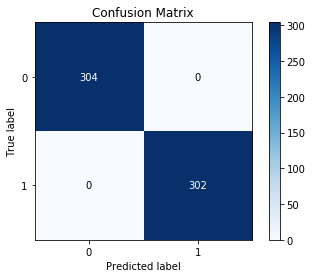

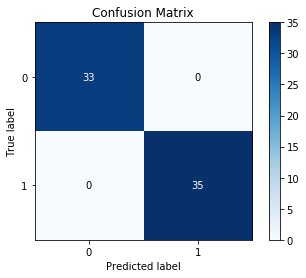

In [48]:

plot_confusion_matrix(y_train,y_pred_train)

plot_confusion_matrix(y_test,y_pred_test)

In [26]:
# Approach 2 Word_embedding Approach

In [57]:
text=text_after_normalizing # Store the text_after_normalizing in text list

In [68]:
tokenizer=Tokenizer(num_words=1000,oov_token="<oov_tok>")  # Mapping the tokens in to numbers
tokenizer.fit_on_texts(text)
word_index=tokenizer.word_index
print("Len_word_Index: "+str(len(word_index)))
train_sequences=tokenizer.texts_to_sequences(text)

Len_word_Index: 30892


In [70]:
word_len=[]   # Contains the legth of Training Data
for i in range(len(train_sequences)):
    word_len.append(len(train_sequences[i]))

Max Len: 3959


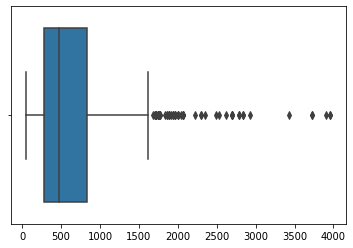

In [75]:
# Lets see the distribution of the word_length
import seaborn as sns
sns.boxplot(word_len)
print("Max Len: "+str(max(word_len)))   # Max length of any doc is 3959 tokens

In [80]:
train_padded=pad_sequences(train_sequences,maxlen=3900,truncating="post")  # PreparinG out the Text by restricting the length 
                                                                           # to the max_length

In [81]:
X=pd.DataFrame(train_padded)  # So the features are stored in a X df
y=pd.DataFrame(label)         # Labels are stored in y data frame as convention


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=121)  # Let's split the data in train and test
print("y_train_shape: "+str(y_train.shape))  # Let's print out the shape
print("y_test_shape: "+str(y_test.shape))
print("X_train_shape: "+str(X_train.shape))
print("X_test_shape: "+str(X_test.shape))

y_train_shape: (606, 1)
y_test_shape: (68, 1)
X_train_shape: (606, 3900)
X_test_shape: (68, 3900)


In [60]:
unique_words=[]
for i in range(len(text)):
    
    tokens= nltk.word_tokenize(text[i])
    
    for j in tokens:
        
        if j  not in unique_words:
            unique_words.append(j)
#Calculating the No. of Unique words            

In [61]:
print("Len of Unique words: "+str(len(unique_words)))

Len of Unique words: 31032


In [94]:
# Approach-2 using Neural networks by adding a first layer of word embedding to convert the simple mapped tokens in 64 dimensional
# vectors on the basis of semantics similarities 
import keras
unique_word_len=  len(unique_words)
dimensions=64               # A word can be represented in a 64 dimension vector
model=keras.models.Sequential([   keras.layers.embeddings.Embedding(unique_word_len,dimensions,input_length=(3900)),
                               
                                  keras.layers.Flatten(),
                               keras.layers.Dense(1,activation='sigmoid')
                                  
    
    
    
])

In [93]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test))  # Lets train our model for 5 epochs

Train on 606 samples, validate on 68 samples
Epoch 1/5
606/606 [==============================] - 3s 5ms/step - loss: 0.0491 - accuracy: 0.9835 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 2/5
606/606 [==============================] - 3s 6ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 3/5
606/606 [==============================] - 3s 6ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 4/5
606/606 [==============================] - 3s 4ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 5/5
606/606 [==============================] - 3s 4ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 1.0000


In [27]:
#Neural Networks performed with 100%naccu on both training and validation set

In [37]:
# Unsupervised Learning Approach
tokenizer=Tokenizer(num_words=1000,oov_token="<oov_tok>")  # Mapping the tokens in to numbers
tokenizer.fit_on_texts(text_after_normalizing)
word_index=tokenizer.word_index
print("Len_word_Index: "+str(len(word_index)))
train_sequences=tokenizer.texts_to_sequences(text_after_normalizing)


Len_word_Index: 30892


In [39]:
#Let's see the first document after preprocessing
train_sequences[0]   # 1 is the no. for out of vocabulary word

[1,
 1,
 1,
 856,
 64,
 119,
 241,
 1,
 1,
 215,
 1,
 1,
 468,
 1,
 13,
 1,
 1,
 15,
 143,
 1,
 261,
 1,
 1,
 1,
 766,
 1,
 857,
 541,
 62,
 639,
 3,
 5,
 4,
 410,
 856,
 598,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 317,
 1,
 1,
 856,
 228,
 630,
 288,
 117,
 856,
 11,
 1,
 350,
 214,
 856,
 11,
 58,
 34,
 256,
 2,
 101,
 318,
 288,
 32,
 1,
 797,
 1,
 856,
 34,
 1,
 353,
 1,
 1,
 396,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 485,
 485,
 308,
 1,
 1,
 1,
 1,
 1,
 706,
 1,
 81,
 1,
 56,
 97,
 146,
 1,
 1,
 594,
 758,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 320,
 1,
 356,
 1,
 1,
 1,
 534,
 330,
 413,
 1,
 856,
 58,
 2,
 517,
 83,
 1,
 414,
 267,
 1,
 619,
 1,
 331,
 43,
 319,
 119,
 1,
 221,
 1,
 549,
 881,
 91,
 1,
 676,
 293,
 331,
 535,
 1,
 1,
 12,
 25,
 430,
 206,
 1,
 298,
 1,
 1,
 425,
 332,
 1,
 234,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 649,
 222,
 1,
 1,
 1,
 110,
 825,
 1,
 1,
 526,
 153,
 1,
 1,
 1,
 106,
 57,
 1,
 1,
 1,
 153,
 88,
 1,
 825,
 1,
 1,
 188,
 30,
 1,
 91,
 289,
 535,
 1,
 380,
 103,

In [43]:
train_padded=pad_sequences(train_sequences,maxlen=3900,truncating="post") #Since the max length of a doc is 3959

In [47]:

df=pd.DataFrame(train_padded)
print(df.shape)

km=KMeans(n_clusters=2)
df['predicted_label']=km.fit_predict(df)

(674, 3900)


In [48]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,3891,3892,3893,3894,3895,3896,3897,3898,3899,predicted_label
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,192,922,415,1,0
1,0,0,0,0,0,0,0,0,0,0,...,94,7,1,1,1,1,520,382,1,1
2,0,0,0,0,0,0,0,0,0,0,...,1,7,116,1,1,1,520,382,1,0
3,0,0,0,0,0,0,0,0,0,0,...,515,1,922,685,518,353,413,7,116,1
4,0,0,0,0,0,0,0,0,0,0,...,914,23,1,914,1,348,1,1,7,0


In [51]:
label= pd.DataFrame(label)
label.columns=['label']
label.head()

,label
0,0
1,0
2,0
3,0
4,0


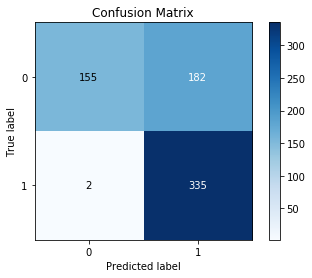

In [52]:
# Let's see how accurate is our Unsupervised approach

plot_confusion_matrix(label['label'],df['predicted_label'])   #0--> blog
                                                                # 1-----> news
    
# Unsupervised Algorithm is not performing so well.
# It has wrongly classified majority of the blog Data Points

In [54]:
# Let's use PCA for dimensionality Reduction
pca=PCA(n_components=2)
df_new=df.drop(['predicted_label'],axis=1)
df_trans=pca.fit_transform(df_new)
df_trans=pd.DataFrame(df_trans)
df_trans.head()

,0,1
0,2910.307357,-1726.997544
1,213.088351,-1393.238752
2,2904.223493,-706.656214
3,241.807345,-1470.687257
4,3723.011157,-1361.055951


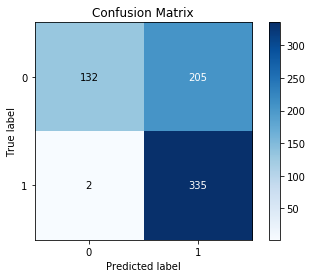

In [55]:
km=KMeans(n_clusters=2)
df_trans['predicted_label']=km.fit_predict(df_trans)
plot_confusion_matrix(label['label'],df_trans['predicted_label'])  

# The performance is even worse in case of PCA